<a href="https://colab.research.google.com/github/dvd3110/Major_Project_2/blob/main/Lung_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Define paths to the training, validation, and test datasets
train_folder = '/content/drive/MyDrive/dataset/train'
test_folder = '/content/drive/MyDrive/dataset/test'
validate_folder = '/content/drive/MyDrive/datasetvalid'

In [4]:
# Define paths to the specific classes within the dataset
normal_folder = '/normal'
adenocarcinoma_folder = '/adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib'
large_cell_carcinoma_folder = '/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa'
squamous_cell_carcinoma_folder = '/squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa'


In [5]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout2D, Activation, Lambda, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils

print("Libraries Imported")

Libraries Imported


In [6]:
# Set the image size for resizing
IMAGE_SIZE = (350, 350)

In [7]:
# Initialize the image data generators for training and testing
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Define the batch size for training
batch_size = 8


In [10]:
# Create the training data generator
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)

Found 256 images belonging to 4 classes.


In [11]:
# Create the validation data generator
validation_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)

Found 315 images belonging to 4 classes.


In [15]:
checkpointer = ModelCheckpoint(
    filepath='best_model.keras',  # Change extension to .keras
    verbose=2,
    save_best_only=True,
    save_weights_only=False  # Ensure the full model is saved
)


In [16]:
# Define the number of output classes
OUTPUT_SIZE = 4

# Load a pre-trained model (Xception) without the top layers and freeze its weights
pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
# Create a new model with the pre-trained base and additional layers for classification
model = Sequential()
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(OUTPUT_SIZE, activation='softmax'))

print("Pretrained model used:")
pretrained_model.summary()

print("Final model created:")
model.summary()


Pretrained model used:


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 350, 350, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 174, 174, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 174, 174, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 174, 174, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 172, 172, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 172, 172, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 172, 172, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 172, 172, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 172, 172, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 172, 172, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 172, 172, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 172, 172, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 86, 86, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 86, 86, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

Final model created:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 11, 11, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           8,196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,869,676 (79.61 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [18]:
# Compile the model with an optimizer, loss function, and evaluation metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [21]:
# Train the model with the training and validation data generators
history = model.fit(
    train_generator,
    steps_per_epoch=25,
    epochs=5,
    callbacks=[learning_rate_reduction, early_stops, checkpointer],
    validation_data=validation_generator,
    validation_steps=20
)
print("Final training accuracy =", history.history['accuracy'][-1])
print("Final testing accuracy =", history.history['val_accuracy'][-1])


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8244 - loss: 0.4175
Epoch 1: val_loss did not improve from 3.35063
25/25 ━━━━━━━━━━━━━━━━━━━━ 246s 10s/step - accuracy: 0.8229 - loss: 0.4188 - val_accuracy: 0.3313 - val_loss: 4.3956 - learning_rate: 0.0010
Epoch 2/5
 7/25 ━━━━━━━━━━━━━━━━━━━━ 1:37 5s/step - accuracy: 0.7707 - loss: 0.3925
Epoch 2: val_loss did not improve from 3.35063
25/25 ━━━━━━━━━━━━━━━━━━━━ 202s 8s/step - accuracy: 0.7944 - loss: 0.3823 - val_accuracy: 0.4187 - val_loss: 3.6761 - learning_rate: 0.0010
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7585 - loss: 0.4472
Epoch 3: val_loss did not improve from 3.35063
25/25 ━━━━━━━━━━━━━━━━━━━━ 233s 10s/step - accuracy: 0.7597 - loss: 0.4463 - val_accuracy: 0.3938 - val_loss: 4.0740 - learning_rate: 0.0010
Epoch 4/5
 7/25 ━━━━━━━━━━━━━━━━━━━━ 1:32 5s/step - accuracy: 0.7158 - loss: 0.4947
Epoch 4: val_loss did not improve from 3.35063
25/25 ━━━━━━━━━━━━━━━━━━━━ 148s 6s/step - accuracy: 0.7661

In [22]:
# Function to display training curves for loss and accuracy
def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])


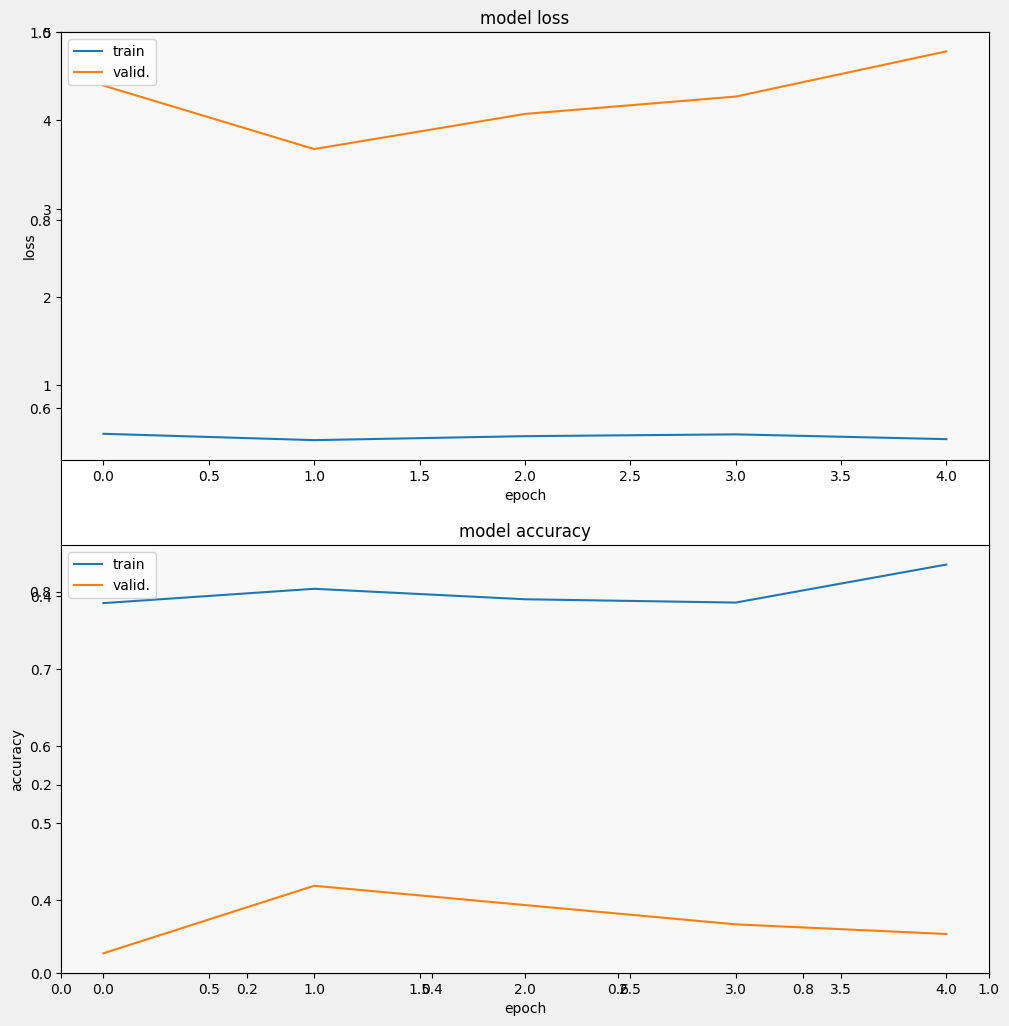

In [23]:
# Display training curves for loss and accuracy
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)


In [24]:
# Save the trained model
model.save('/content/drive/MyDrive/dataset/trained_lung_cancer_model.h5')

In [25]:
# Function to load and preprocess an image for prediction
from tensorflow.keras.preprocessing import image
import numpy as np

def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image like the training images
    return img_array


In [28]:
# Load, preprocess, and predict the class of an image
img_path = '/content/drive/MyDrive/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000109.png'
img = load_and_preprocess_image(img_path, IMAGE_SIZE)
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])
class_labels = list(train_generator.class_indices.keys())
predicted_label = class_labels[predicted_class]

print(f"The image belongs to class: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
The image belongs to class: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib


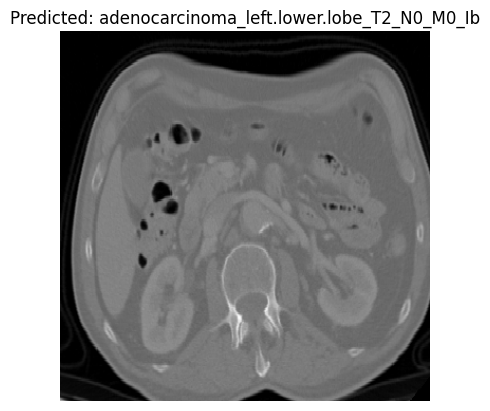

In [29]:
# Display the image with the predicted class
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
The image belongs to class: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib


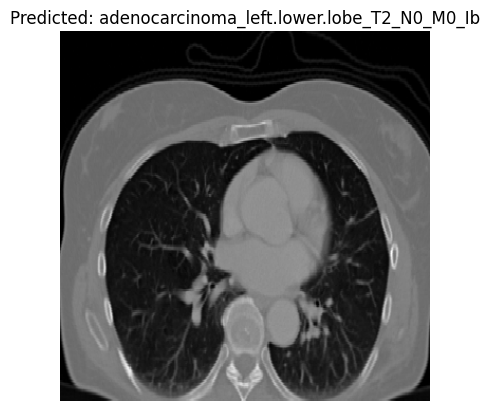

In [31]:
# Repeat the process for additional images
img_path = '/content/drive/MyDrive/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000111 (2).png'
img = load_and_preprocess_image(img_path, IMAGE_SIZE)
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])
predicted_label = class_labels[predicted_class]
print(f"The image belongs to class: {predicted_label}")
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
The image belongs to class: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib


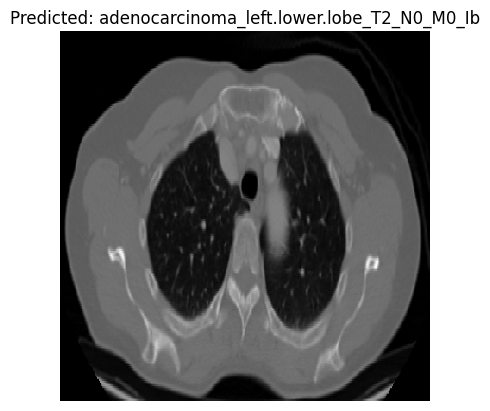

In [33]:
img_path = '/content/drive/MyDrive/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000118 (2).png'
img = load_and_preprocess_image(img_path, IMAGE_SIZE)
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])
predicted_label = class_labels[predicted_class]
print(f"The image belongs to class: {predicted_label}")
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step
The image belongs to class: adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib


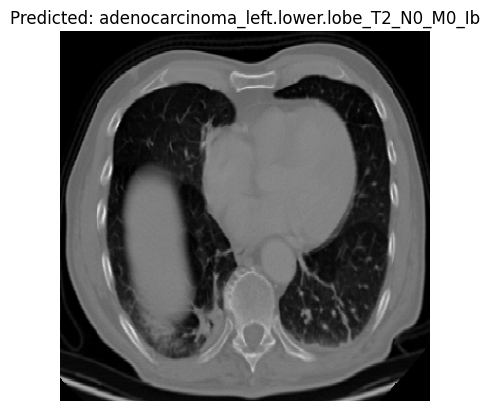

In [32]:
img_path = '/content/drive/MyDrive/valid/large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa/000122.png'
img = load_and_preprocess_image(img_path, IMAGE_SIZE)
predictions = model.predict(img)
predicted_class = np.argmax(predictions[0])
predicted_label = class_labels[predicted_class]
print(f"The image belongs to class: {predicted_label}")
plt.imshow(image.load_img(img_path, target_size=IMAGE_SIZE))
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()